In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

### Agent-Based Modelling Example

Let's review our simple agent-based model.

## Setup

First, create the agents and the environment

In [2]:
# a class to help structure the simulation
class Person:
    alive = True
    age = 0
    sex = "F"
    ill = False
    heartFunction = 1.
    
    # set up a new Person
    def __init__(self, age, sex, ill=False, heartFunction=1.):
        self.age = age
        self.sex = sex
        self.ill = ill
        self.heartFunction = heartFunction

# helper function to generate a connected population of random Persons of the given size.
# If desired, a seed can be provided to the random number generator to facilitate
# comparison between runs.
def generateRandomConnectedPopulation(size, degree=3, seed=None):
    population = []
    contactNetwork = nx.Graph()
    
    # if we want to control the random seed, we can - otherwise it will be automatically set
    if seed is not None:
        np.random.seed(seed)
    
    for i in range(size):
        # Create a new, random Person
        age = int(np.random.uniform(20, 80)) # age is uniform from 20 to 80
        sex = np.random.choice(["F", "M"])   # sex is randomly chosen
        p = Person(age, sex)
        
        # add our new Person to the network
        contactNetwork.add_node(p, label=("Healthy"))

        # connect them to the others in the network
        for j in range(degree): # add at least a few contacts
            n = np.random.choice(contactNetwork.nodes)
            if n is not p:
                contactNetwork.add_edge(p, n)

    population = list(contactNetwork.nodes)
    pos = nx.forceatlas2_layout(contactNetwork)
    
    return population, contactNetwork, pos

Next, create an update function to help the model run.

In [3]:
def step(population, contactNetwork, spread_prob = .3, recover_prob = .3, death_prob = .01):
    for p in population:

        if not p.alive: # don't update dead people
            continue
        
        # if they've died, stop spreading the disease!
        elif p.alive and np.random.rand() * p.heartFunction < death_prob:
            p.alive = False
            continue
            
        # sick people spread the illness
        if p.ill:

            # potentially infect all neighbors
            for n in contactNetwork.neighbors(p):
                if n.alive and np.random.rand() < spread_prob:
                    n.ill = True
            
            # potentially recover
            if np.random.rand() < recover_prob:
                n.ill = False

            # the illness makes us more likely to die - double the risk! Check again
            if np.random.rand() * p.heartFunction < death_prob:
                n.alive = False

Finally, create a helper function to visualise the output.

In [4]:
def visualiseGraph(contactNetwork, population, pos=False):
    # if positions haven't already been set up, set them up
    if not pos:
        pos = nx.forceatlas2_layout(contactNetwork)

    # let's adjust the visualisation!
    colorByAttribute = {"Dead": "grey", "Ill":"red", "Healthy":"green"}
    sizeByAttribute = {"Dead": 15, "Ill":25, "Healthy":10}    
    labels = ["Dead" if not p.alive else "Ill" if p.ill else "Healthy" for p in population]
    nodeColors = [colorByAttribute[x] for x in labels]
    nodeSizes = [sizeByAttribute[x] for x in labels]

    # draw the agents in their environment
    nx.draw_networkx(contactNetwork, pos, with_labels=False, node_color=nodeColors, node_size=nodeSizes, edge_color="grey")
    plt.tight_layout()
    plt.show()

## Simple Example

Let's make a simple example of this model!

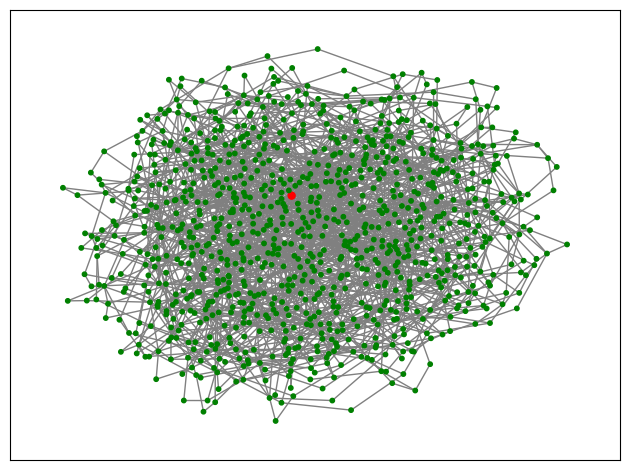

In [5]:
population, contactNetwork, pos = generateRandomConnectedPopulation(1000, degree=2, seed=10)
population[0].ill = True
visualiseGraph(contactNetwork, population, pos)

Note that because we've set the random seed, we can control the way that it displays - and can limit stochasticity to where we want it!

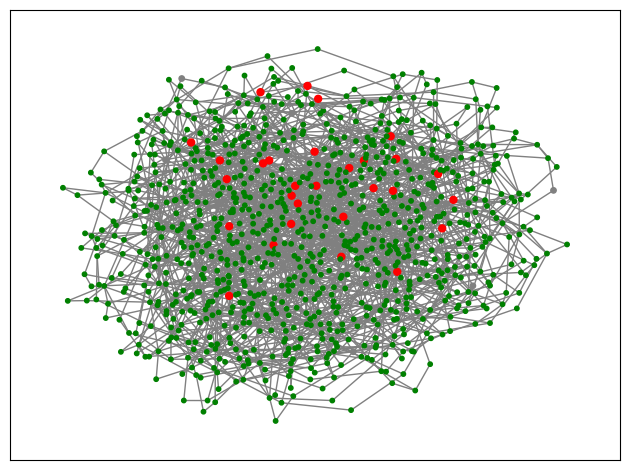

In [6]:
step(population, contactNetwork)
visualiseGraph(contactNetwork, population, pos)

Great, we have our population - now let's simulate what happens over time!

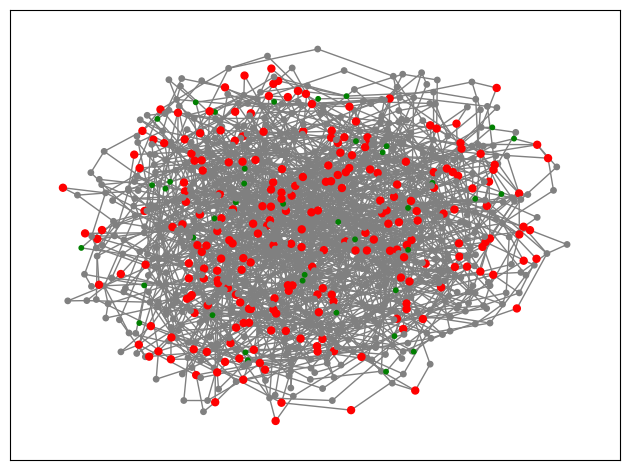

In [7]:
for i in range(100):
    step(population, contactNetwork)
visualiseGraph(contactNetwork, population, pos)

## Making measurements

How can we measure things? Well, lots of ways! Let's start by basics - how many deaths were there?

That's something we can measure at the end of the simulation - just take the final population and count how many have died.

In [8]:
sum([1 if not p.alive else 0 for p in population])

727

Some of these, though, were NOT because of the spread of disease - it was just natural! We can check this by adding a bit of code to the Step function, 

In [9]:
def step(population, contactNetwork, spread_prob = .3, recover_prob = .3, death_prob = .01):

    deathsToIllness = 0 ##################### OUR NEW VARIABLE ##################################

    for p in population:

        if not p.alive: # don't update dead people
            continue
        
        # if they've died, stop spreading the disease!
        elif p.alive and np.random.rand() * p.heartFunction < death_prob:
            p.alive = False
            continue
            
        # sick people spread the illness
        if p.ill:

            # potentially infect all neighbors
            for n in contactNetwork.neighbors(p):
                if n.alive and np.random.rand() < spread_prob:
                    n.ill = True
            
            # potentially recover
            if np.random.rand() < recover_prob:
                n.ill = False

            # the illness makes us more likely to die - double the risk! Check again
            if np.random.rand() * p.heartFunction < death_prob:
                n.alive = False
                deathsToIllness += 1 ##################### UPDATE NEW VARIABLE #####################
                
    return deathsToIllness ##################### RETRURN NEW VARIABLE ###########################

Now, recreate the population and make sure to save the results of this new variable!

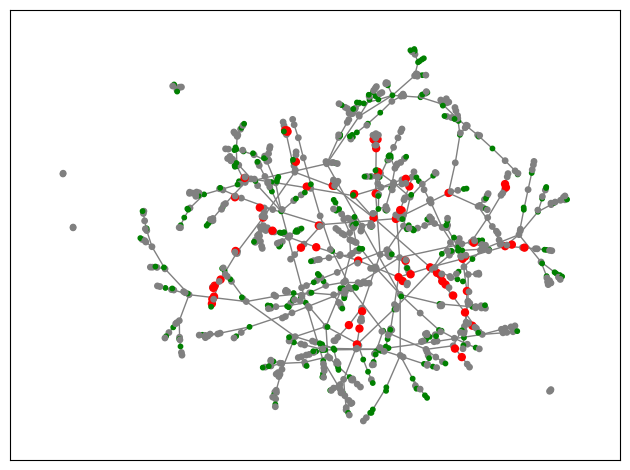

93


In [10]:
# setup
population, contactNetwork, pos = generateRandomConnectedPopulation(1000, degree=1, seed=10)
population[0].ill = True

# run
deathsToIllness = 0
for i in range(100):
    deathsToIllness += step(population, contactNetwork)

# report
visualiseGraph(contactNetwork, population, pos)
print(deathsToIllness)

## Adding time

Ok, so we know how to measure something in the model - why not keep track as the model goes along?

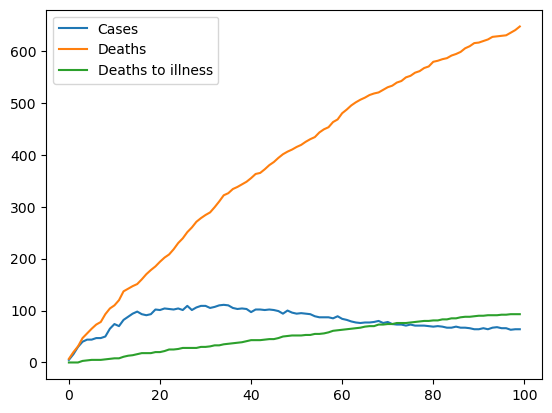

In [11]:
# setup
population, contactNetwork, pos = generateRandomConnectedPopulation(1000, degree=1, seed=10)
population[0].ill = True

# REPORTERS
casesOverTime = []
deathsOverTime = []
deathsToIllnessOverTime = []

# run
deathsToIllness = 0
for i in range(100):

    # update the simulation
    deathsToIllness += step(population, contactNetwork)

    # save the measurements
    casesOverTime.append(sum([1 if p.alive and p.ill else 0 for p in population]))
    deathsOverTime.append(sum([1 if not p.alive else 0 for p in population]))
    deathsToIllnessOverTime.append(deathsToIllness)

# report
plt.plot(casesOverTime, label="Cases")
plt.plot(deathsOverTime, label="Deaths")
plt.plot(deathsToIllnessOverTime, label="Deaths to illness")
plt.legend()
plt.show()

## Multiple runs

Stochasticity means that each run of the model will produce a different result. If we want to know what range of outcomes a model can produce, we need to run it multiple times.

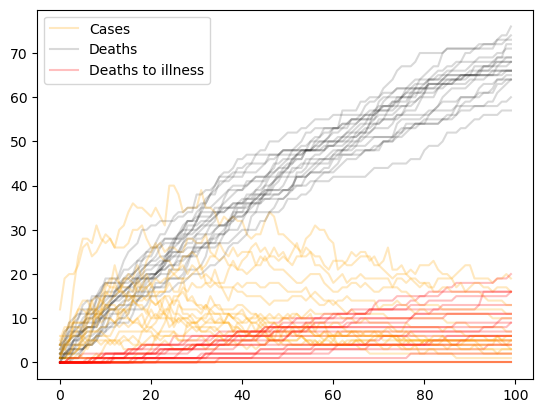

In [12]:
# setup
def runModel(popSize = 100, degree = 1, seed = None, steps = 100, spread_prob=None):

    # set up the simulation environment
    population, contactNetwork, pos = generateRandomConnectedPopulation(popSize, degree, seed)
    population[0].ill = True
   
    # reporters
    casesOverTime = []
    deathsOverTime = []
    deathsToIllnessOverTime = []
    
    # run
    deathsToIllness = 0
    for i in range(steps):
    
        # update the simulation
        if spread_prob is not None:
            deathsToIllness += step(population, contactNetwork, spread_prob = spread_prob)
        else:
            deathsToIllness += step(population, contactNetwork)
    
        # save the measurements
        casesOverTime.append(sum([1 if p.alive and p.ill else 0 for p in population]))
        deathsOverTime.append(sum([1 if not p.alive else 0 for p in population]))
        deathsToIllnessOverTime.append(deathsToIllness)

    return casesOverTime, deathsOverTime, deathsToIllnessOverTime

# run 20 different versions of the model, all with different random seeds
for i in range(20):
    c, d, d_i = runModel(seed=i, spread_prob = .3)
    
    # report
    plt.plot(c, color="orange", label="Cases", alpha=.25)
    plt.plot(d, color="black", label="Deaths", alpha=.15)
    plt.plot(d_i, color="red", label="Deaths to illness", alpha=.25)
legend = plt.legend(["Cases", "Deaths", "Deaths to illness"])
plt.show()

## Varying the scenario

What happens if we change something about the world?

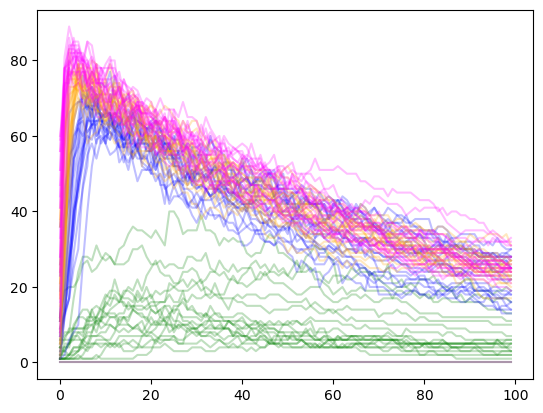

In [13]:
# let's change the way we set up the network, increasing the number of connections each individual
# is initialised to have!
colorByDegree = {1: "green", 2: "blue", 3: "orange", 4: "magenta"}
for myDegree in [1, 2, 3, 4]:
    
    # run 20 different versions of the SCENARIO, all with different random seeds
    for i in range(20):
        c, d, d_i = runModel(degree=myDegree, seed=i)
        
        # report
        plt.plot(c, label=str(myDegree), color=colorByDegree[myDegree], alpha=.25)

#plt.legend()
plt.show()

Try varying the infectiousness too!

**Please note: this takes a bit longer to run**

.
.
.
.
.
.


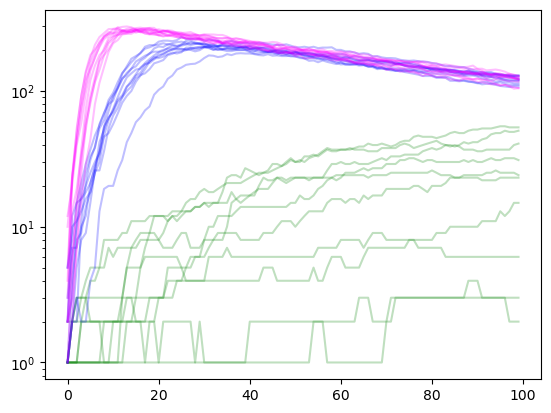

In [14]:
# let's change the infectiousness of the disease
colorByInfect = {.01: "green", .05: "blue", .1: "magenta"}
for beta in colorByInfect.keys():
    
    # run different versions of the SCENARIO, all with different random seeds
    for i in range(10):
        c, d, d_i = runModel(popSize = 500, degree=3, seed=i, spread_prob = beta)
        
        # report
        plt.plot(c, color=colorByInfect[beta], alpha=.25)
        if i % 5 == 0:
            print('.')

#plt.legend()
plt.yscale("log")
plt.show()

## Adding new behaviours...

We can also try to layer different attributes or behaviours on top of one another. For example, we can use a (simplistic!) representation of heart health to track the burden of disease, and to see how it might influence death rates.

Let's assume that for every step of the simulation that someone is ill, they lose a fraction of hearth health. If we calculate the likelihood of dying with heart function as a limiting factor, how will increasingly damaging illnesses translate into system-level outcomes?

In [15]:
# a new step function - now with the heart function of ill persons being updated based on the duration of the disease
def step(population, contactNetwork, spread_prob = .3, recover_prob = .3, death_prob = .01, damage_to_heart = .0):

    deathsToIllness = 0
    
    for p in population:

        if not p.alive: # don't update dead people
            continue
        
        # if they've died, stop spreading the disease!
        elif p.alive and np.random.rand() * p.heartFunction < death_prob:
            p.alive = False
            continue
            
        # sick people spread the illness
        if p.ill:

            ############################# being ill may increase likelihood of death! ############################
            p.heartFunction -= damage_to_heart
            ######################################################################################################
            
            # potentially infect all neighbors
            for n in contactNetwork.neighbors(p):
                if n.alive and np.random.rand() < spread_prob:
                    n.ill = True
                    # NOTE: if you wanted to, instead, suggest that damage occurs *per infection*, rather than 
                    # *per day* of the infection, you might instead update the neighbour n's heartFunction parameter
                    # here, when they get infected.
            
            # potentially recover
            if np.random.rand() < recover_prob:
                n.ill = False

            # the illness makes us more likely to die - double the risk! Check again
            if np.random.rand() * p.heartFunction < death_prob:
                n.alive = False
                deathsToIllness += 1

    return deathsToIllness


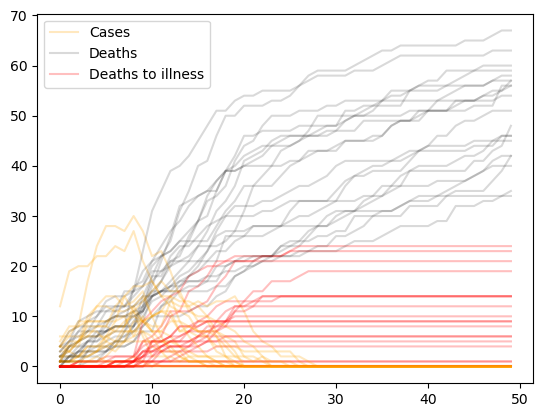

In [16]:
# a new setup function, which accepts the amount of damage the heart takes each step as a parameter.
# Consider experimenting with different parameter ranges for all of the parameters!
def runModel(popSize = 100, degree = 1, seed = None, steps = 100, spread_prob=None, damage_to_heart = .0):

    # set up the simulation environment
    population, contactNetwork, pos = generateRandomConnectedPopulation(popSize, degree, seed)
    population[0].ill = True
   
    # reporters
    casesOverTime = []
    deathsOverTime = []
    deathsToIllnessOverTime = []
    
    # run
    deathsToIllness = 0
    for i in range(steps):
    
        # update the simulation
        if spread_prob is not None:
            deathsToIllness += step(population, contactNetwork, spread_prob = spread_prob, damage_to_heart = damage_to_heart)
        else:
            deathsToIllness += step(population, contactNetwork, damage_to_heart = damage_to_heart)
    
        # save the measurements
        casesOverTime.append(sum([1 if p.alive and p.ill else 0 for p in population]))
        deathsOverTime.append(sum([1 if not p.alive else 0 for p in population]))
        deathsToIllnessOverTime.append(deathsToIllness)

    return casesOverTime, deathsOverTime, deathsToIllnessOverTime

# run 20 different versions of the model, all with different random seeds
for i in range(20):
    c, d, d_i = runModel(seed=i, spread_prob = .3, damage_to_heart = .1, steps=50)
    
    # report
    plt.plot(c, color="orange", label="Cases", alpha=.25)
    plt.plot(d, color="black", label="Deaths", alpha=.15)
    plt.plot(d_i, color="red", label="Deaths to illness", alpha=.25)
legend = plt.legend(["Cases", "Deaths", "Deaths to illness"])
plt.show()

Ok, let's try varying the impact of the illness on heart health.

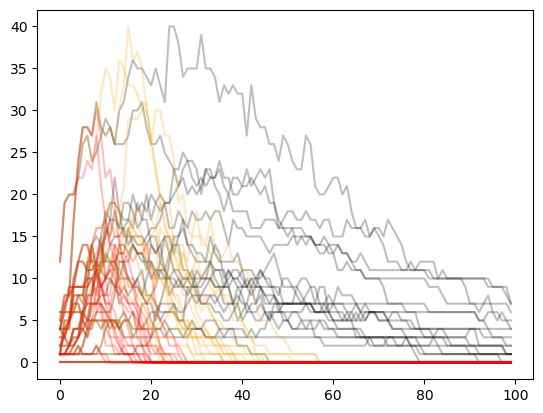

In [17]:
# let's try different levels of heart impact
colorByHeartDamage = {.01: "black", .05: "orange", .1: "red"}
for damage in colorByHeartDamage.keys():
    
    # run 20 different versions of the SCENARIO, all with different random seeds
    for i in range(20):
        c, d, d_i = runModel(seed=i, damage_to_heart=damage)
        
        # report
        plt.plot(c, label=str(damage), color=colorByHeartDamage[damage], alpha=.25)

#plt.legend()
plt.show()